In [1]:
from MoCo.utils import get_transform
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
from tqdm import tqdm
from MoCo.wideresnet import WideResNet
from torch.nn import functional as F
import types
import MoCo.config as config
from torchvision import transforms
import pickle
import os

In [2]:
config.DEVICE

device(type='cuda', index=0)

In [16]:
save_path = './models/MoCov1_weights.pt'

In [17]:
def random_int(n=100):
    return np.random.randint(0, n, 1)[0]


def get_model():
    model = WideResNet
    model_q = model(pretrained=None)

    def forward(self, input):
        x = self.features(input)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        x = F.normalize(x)  # l2 normalize by default
        
        return x

    model_q.forward = types.MethodType(forward, model_q)
    model_q.to(config.DEVICE)
    
    if os.path.isfile(config.FILE_PATH):
        print(f'loading model from {save_path}')
        checkpoint = torch.load(save_path, map_location=config.DEVICE)
        
        # config.__dict__.update(checkpoint['config'])
        model_q.load_state_dict(checkpoint['model_q'])  # 학습된 가중치 load
        # model_q = model_q.module
        
    return model_q

In [18]:
# data
label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
image_size = 32

cifar10_mean = (0.4914, 0.4822, 0.4465)  # equals np.mean(train_set.train_data, axis=(0,1,2))/255
cifar10_std = (0.2471, 0.2435, 0.2616)  # equals np.std(train_set.train_data, axis=(0,1,2))/255

transform_to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
    ])

test_transform = get_transform(image_size, mode='test', to_tensor=False)

dataset = datasets.cifar.CIFAR10(root='./', train=True, transform=test_transform,
                                 download=True)


# inference
features = []
labels = []

model_q = get_model()  # pre-trained encoder
model_q.eval()

if os.path.exists('./feature.pkl'):
    with open('./feature.pkl', 'rb') as f:
        features = pickle.load(f)  # (50000, ) - 128차원의 representation이 50000개 존재
        labels = pickle.load(f)  # (50000, )
        
else:
    with torch.no_grad():
        for img, label in tqdm(dataset):
            labels.append(label_list[label])
            img = transform_to_tensor(img).to(config.DEVICE)
            img = img.unsqueeze(0)  # batch 차원 삭제
            
            feat = model_q(img)  # 1x128 - encoding (128차원의 representation으로)
            features.append(feat.cpu().numpy()[0])
    
    # 저장
    with open('./feature.pkl', 'wb') as f:
        pickle.dump(features, f)
        pickle.dump(labels, f)
        

features = np.stack(features)  # (50000, 128)        
        
pos_idx = random_int(len(features))  # 랜덤한 index 하나
pos_sample, pos_label = features[pos_idx], labels[pos_idx]

# candidate_sample, candidate_label = features[:pos_idx] + features[pos_idx + 1:], labels[:pos_idx] + labels[pos_idx + 1, :]
tensor_pos_sample = torch.tensor(pos_sample).to(config.DEVICE).unsqueeze(0)  # (1, 128)
tensor_candidate_sample = torch.tensor(features).to(config.DEVICE).transpose(0, 1)  # (128, 50000)

result = torch.mm(tensor_pos_sample, tensor_candidate_sample).cpu().numpy()[0]  # (50000, ) - 내적을 통해 pos_sample과의 유사도 계산

sim_with_label = [(sim, i) for i, sim in enumerate(result)]
sim_with_label.sort(key=lambda x: x[0])  # small to large

Files already downloaded and verified


In [19]:
sim_with_label[:8]  # (유사도, index)

[(0.8753602, 4651),
 (0.87569505, 26631),
 (0.8813374, 403),
 (0.8818616, 26969),
 (0.8818997, 16734),
 (0.88388455, 8863),
 (0.88417655, 47093),
 (0.88554823, 24650)]

In [20]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

5
50000


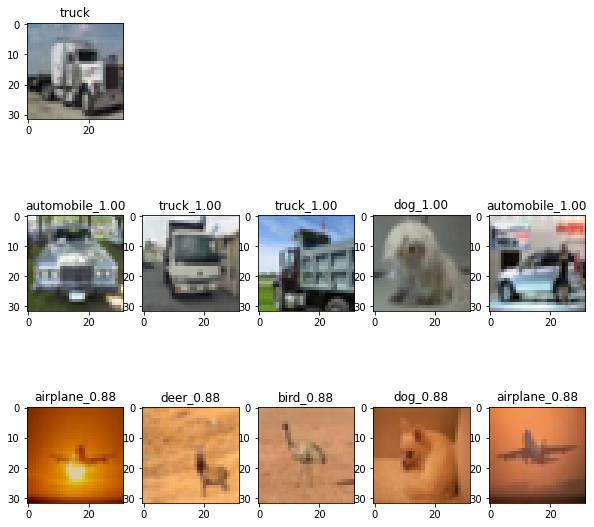

In [21]:
# original img
col_num = 5
f = plt.figure(figsize=(10, 10))
pos_img, _ = dataset[pos_idx]

f.add_subplot(3, col_num, 1)
plt.imshow(pos_img)
plt.title(pos_label)

# positive img
large_sim = sim_with_label[-col_num - 1:-1]
print(len(large_sim))
print(len(sim_with_label))

for i in range(col_num):
    score, idx = large_sim[i]
    img, _ = dataset[idx]
    label = labels[idx]
    
    f.add_subplot(3, col_num, i + 1 + col_num)
    plt.imshow(img)
    plt.title(f'{label}_{score:.2f}')
    
# negative img
sm_sim = sim_with_label[:col_num]
for i in range(col_num):
    score, idx = sm_sim[i]
    img, _ = dataset[idx]
    label = labels[idx]
    
    f.add_subplot(3, col_num, i + 1 + col_num * 2)
    plt.imshow(img)
    plt.title(f'{label}_{score:.2f}')